In [1]:
#Import the data for the temperature in the city of Madrid.
# Source: https://www.ncei.noaa.gov/cdo-web/ 

import pandas as pd
import matplotlib.pyplot as plt

# Import the Excel file and parse the "Date" column as datetime,
# setting it as the index.
data = pd.read_csv("Precipitation-data.csv", index_col="DATE", parse_dates=["DATE"])

Select only the last two years of data to be abe to capture the trend and/or the seasonality .As it is daily data we take into consideration the last 730 days

In [8]:
data_subset  =data.iloc[-730:,:]
data_subset.head()

,STATION,NAME,LATITUDE,LONGITUDE,ELEVATION,PRCP,PRCP_ATTRIBUTES,SNWD,SNWD_ATTRIBUTES,TAVG,TAVG_ATTRIBUTES,TMAX,TMAX_ATTRIBUTES,TMIN,TMIN_ATTRIBUTES
DATE,,,,,,,,,,,,,,,
2023-11-01,SPE00120278,"MADRID BARAJAS, SP",40.4667,-3.5556,609.0,1.4,",,E",NaN,NaN,11.9,"H,,S",15.9,",,E",6.3,",,E"
2023-11-02,SPE00120278,"MADRID BARAJAS, SP",40.4667,-3.5556,609.0,7.5,",,E",NaN,NaN,13.0,"H,,S",17.1,",,E",8.1,",,E"
2023-11-03,SPE00120278,"MADRID BARAJAS, SP",40.4667,-3.5556,609.0,0.1,",,E",NaN,NaN,10.7,"H,,S",14.9,",,E",7.5,",,E"
2023-11-04,SPE00120278,"MADRID BARAJAS, SP",40.4667,-3.5556,609.0,1.1,",,E",NaN,NaN,12.3,"H,,S",15.3,",,E",10.1,",,E"
2023-11-05,SPE00120278,"MADRID BARAJAS, SP",40.4667,-3.5556,609.0,0.0,",,E",NaN,NaN,11.3,"H,,S",14.9,",,E",9.0,",,E"


# Null values identification

In [9]:
#Identify how many None values do we have in the two years of data that we selected for the analysis
data_subset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2023-11-01 to 2025-10-30
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATION          730 non-null    object 
 1   NAME             730 non-null    object 
 2   LATITUDE         730 non-null    float64
 3   LONGITUDE        730 non-null    float64
 4   ELEVATION        730 non-null    float64
 5   PRCP             667 non-null    float64
 6   PRCP_ATTRIBUTES  667 non-null    object 
 7   SNWD             0 non-null      float64
 8   SNWD_ATTRIBUTES  0 non-null      object 
 9   TAVG             652 non-null    float64
 10  TAVG_ATTRIBUTES  652 non-null    object 
 11  TMAX             729 non-null    float64
 12  TMAX_ATTRIBUTES  729 non-null    object 
 13  TMIN             730 non-null    float64
 14  TMIN_ATTRIBUTES  730 non-null    object 
dtypes: float64(8), object(7)
memory usage: 91.2+ KB


The results show that in the column of interest, that is the TAVG: average temperarature,
we have 78 days where we don't have the information for of the temperature

# None values treatment:
In order to solve the issues of the null values and considering the seasonality of the data, we consider that the best method
to fill in the null value is by interpolation taking the nearest no null value. In that way we can avoid biases or any negative influence of those 
inputed values when fitting a model.

In [10]:
data_subset = data_subset.interpolate(method='nearest')

C:\Users\ricar\AppData\Local\Temp\ipykernel_28464\3705256034.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data_subset = data_subset.interpolate(method='nearest')


In [11]:
#Verification that there are not more null values in our variable of interest
data_subset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 730 entries, 2023-11-01 to 2025-10-30
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   STATION          730 non-null    object 
 1   NAME             730 non-null    object 
 2   LATITUDE         730 non-null    float64
 3   LONGITUDE        730 non-null    float64
 4   ELEVATION        730 non-null    float64
 5   PRCP             730 non-null    float64
 6   PRCP_ATTRIBUTES  667 non-null    object 
 7   SNWD             0 non-null      float64
 8   SNWD_ATTRIBUTES  0 non-null      object 
 9   TAVG             663 non-null    float64
 10  TAVG_ATTRIBUTES  652 non-null    object 
 11  TMAX             730 non-null    float64
 12  TMAX_ATTRIBUTES  729 non-null    object 
 13  TMIN             730 non-null    float64
 14  TMIN_ATTRIBUTES  730 non-null    object 
dtypes: float64(8), object(7)
memory usage: 91.2+ KB


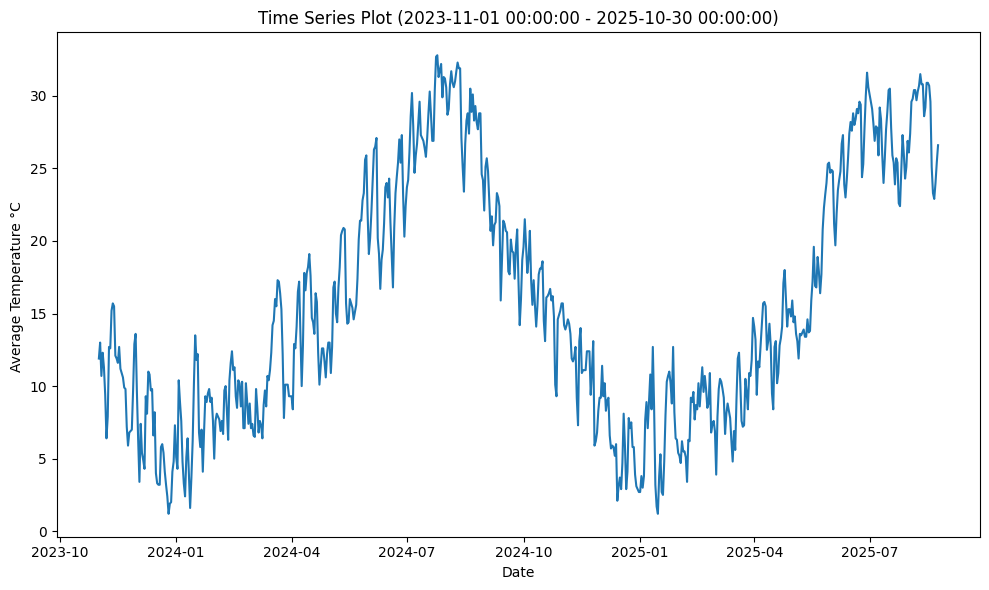

In [12]:

# Plot the time series of the average temperature in Madrid over the course of the last two years

plt.figure(figsize=(10, 6))
plt.plot(data_subset.index, data_subset['TAVG'], linestyle='-')
plt.title(f"Time Series Plot ({(list(data_subset.index)[0])} - {list(data_subset.index)[-1]})")
plt.xlabel("Date")
plt.ylabel("Average Temperature °C ")
plt.tight_layout()
plt.show()


It is clear that there is a seasonality i the data every year / 365 days approximately, aditionally it seems to be
an increasing trend in the avg. temperature

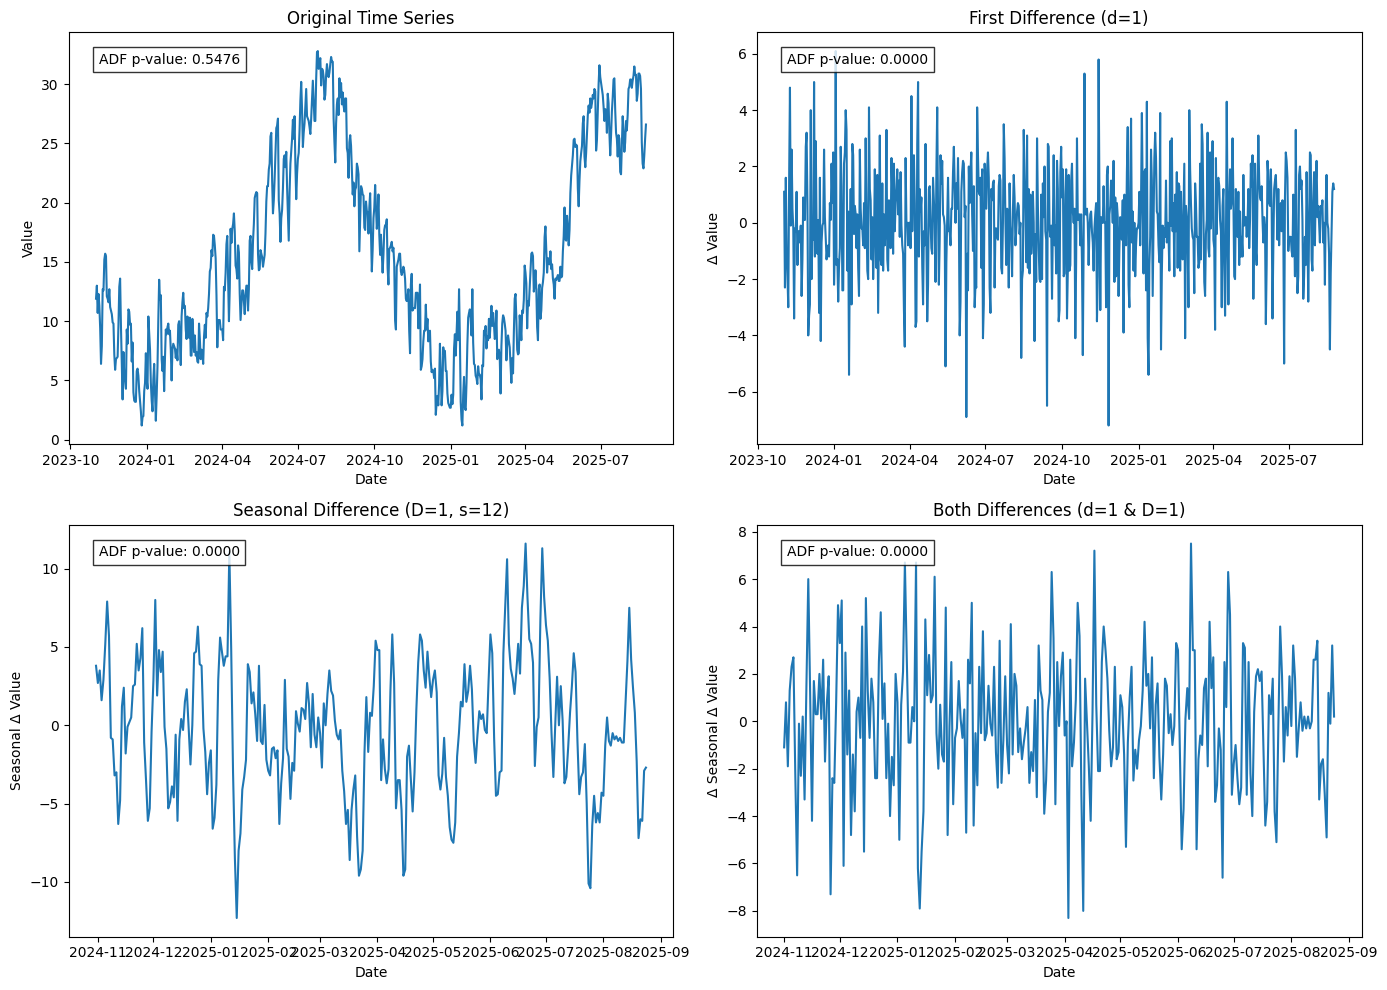

In [13]:
# We run the dicky Fuller test on the series to identify if the series is stationary

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller

# Assume the time series values are in the first column
series = data_subset['TAVG']

# We calculate the firs (non-seasonal) difference
diff_series = series.diff().dropna()

# The graph indicates that there is a yearly sesonality, considering that we have daily data
# we make the diffiratiation with a lag of 365 days.
seasonal_diff = series.diff(365).dropna()

# Both differences: apply first difference then seasonal difference
both_diff = diff_series.diff(365).dropna()

# Compute ADF test p-values for each series
adf_original = adfuller(series.dropna())
p_value_original = adf_original[1]

adf_diff = adfuller(diff_series)
p_value_diff = adf_diff[1]

adf_seasonal = adfuller(seasonal_diff)
p_value_seasonal = adf_seasonal[1]

adf_both = adfuller(both_diff)
p_value_both = adf_both[1]

# Create a 2x2 grid of plots
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Top-Left: Original time series with ADF p-value annotation
axs[0, 0].plot(series, linestyle='-')
axs[0, 0].set_title("Original Time Series")
axs[0, 0].set_xlabel("Date")
axs[0, 0].set_ylabel("Value")
axs[0, 0].text(0.05, 0.95, f"ADF p-value: {p_value_original:.4f}",
               transform=axs[0, 0].transAxes,
               verticalalignment='top',
               bbox=dict(facecolor='white', alpha=0.8))

# Top-Right: First Difference (non-seasonal) with ADF p-value annotation
axs[0, 1].plot(diff_series, linestyle='-')
axs[0, 1].set_title("First Difference (d=1)")
axs[0, 1].set_xlabel("Date")
axs[0, 1].set_ylabel("Δ Value")
axs[0, 1].text(0.05, 0.95, f"ADF p-value: {p_value_diff:.4f}",
               transform=axs[0, 1].transAxes,
               verticalalignment='top',
               bbox=dict(facecolor='white', alpha=0.8))

# Bottom-Left: Seasonal Difference (assumed seasonal period s=12) with ADF p-value annotation
axs[1, 0].plot(seasonal_diff, linestyle='-')
axs[1, 0].set_title("Seasonal Difference (D=1, s=12)")
axs[1, 0].set_xlabel("Date")
axs[1, 0].set_ylabel("Seasonal Δ Value")
axs[1, 0].text(0.05, 0.95, f"ADF p-value: {p_value_seasonal:.4f}",
               transform=axs[1, 0].transAxes,
               verticalalignment='top',
               bbox=dict(facecolor='white', alpha=0.8))

# Bottom-Right: Both Differences (non-seasonal then seasonal) with ADF p-value annotation
axs[1, 1].plot(both_diff,  linestyle='-')
axs[1, 1].set_title("Both Differences (d=1 & D=1)")
axs[1, 1].set_xlabel("Date")
axs[1, 1].set_ylabel("Δ Seasonal Δ Value")
axs[1, 1].text(0.05, 0.95, f"ADF p-value: {p_value_both:.4f}",
               transform=axs[1, 1].transAxes,
               verticalalignment='top',
               bbox=dict(facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()




As shown in the result, the original series is a non-stationary series with a p-value of 0.54
For the rest, the ussing the first and seasonal differatiation seems equivalent, the p-value for 
te three combinations of only first diff., only seasonal diff, and both diffs get a a p-value of 0.0

This might indicate an indifference on what diff to use, further more graph is very simmilar between the three 
options so its not visual evidence that one its better than the other.

Seeing that there is a clear seasonlality and trend in the original series we decided to go for the series where we made both diff.

In order to identify what stationary series is better to use to fit a Seasonal Arima model we use made the ACF and PACF for each of the series. In that way we picked the one were the ACF shows a faster decrease to cero. 

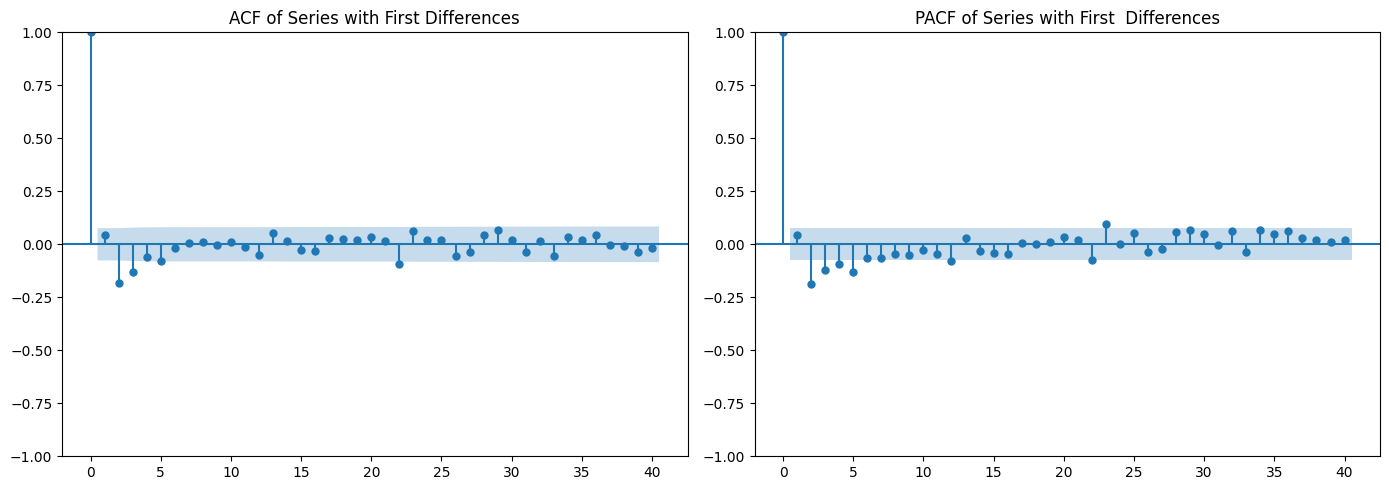

In [14]:
# Create ACF and PACF plots for the series with both differences
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# ACF Plot
sm.graphics.tsa.plot_acf(diff_series, lags=40, ax=axs[0])
axs[0].set_title("ACF of Series with First Differences")

# PACF Plot
sm.graphics.tsa.plot_pacf(diff_series, lags=40, ax=axs[1], method='ywm')
axs[1].set_title("PACF of Series with First  Differences")

plt.tight_layout()
plt.show()

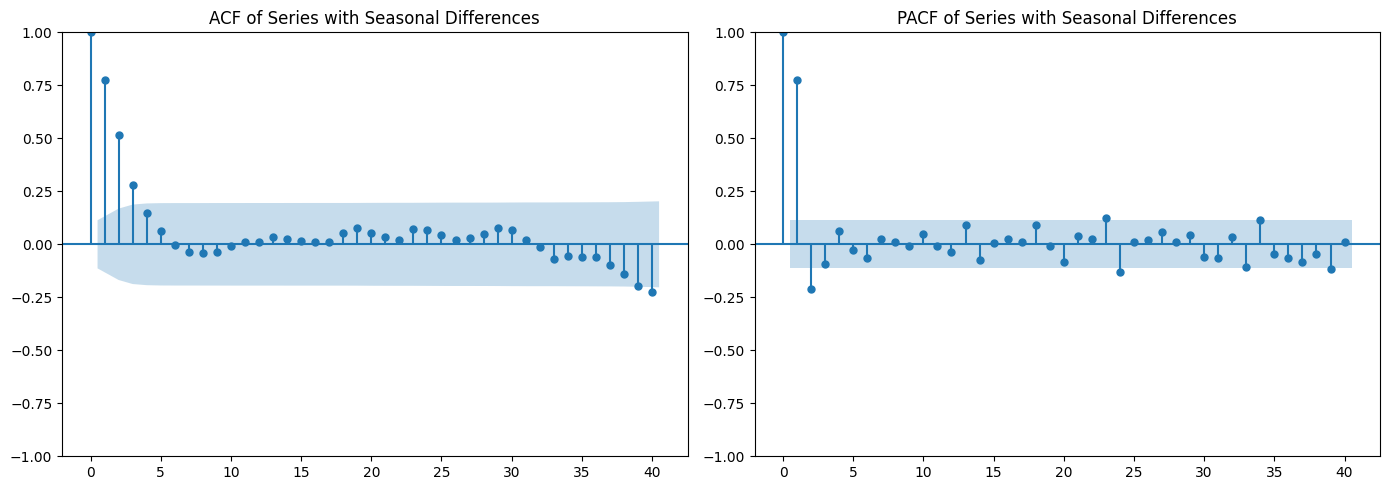

In [ ]:
# Create ACF and PACF plots for the series with Seasonal differences
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# ACF Plot
sm.graphics.tsa.plot_acf(seasonal_diff, lags=40, ax=axs[0])
axs[0].set_title("ACF of Series with Seasonal Differences")

# PACF Plot
sm.graphics.tsa.plot_pacf(seasonal_diff, lags=40, ax=axs[1], method='ywm')
axs[1].set_title("PACF of Series with Seasonal Differences")

plt.tight_layout()
plt.show()

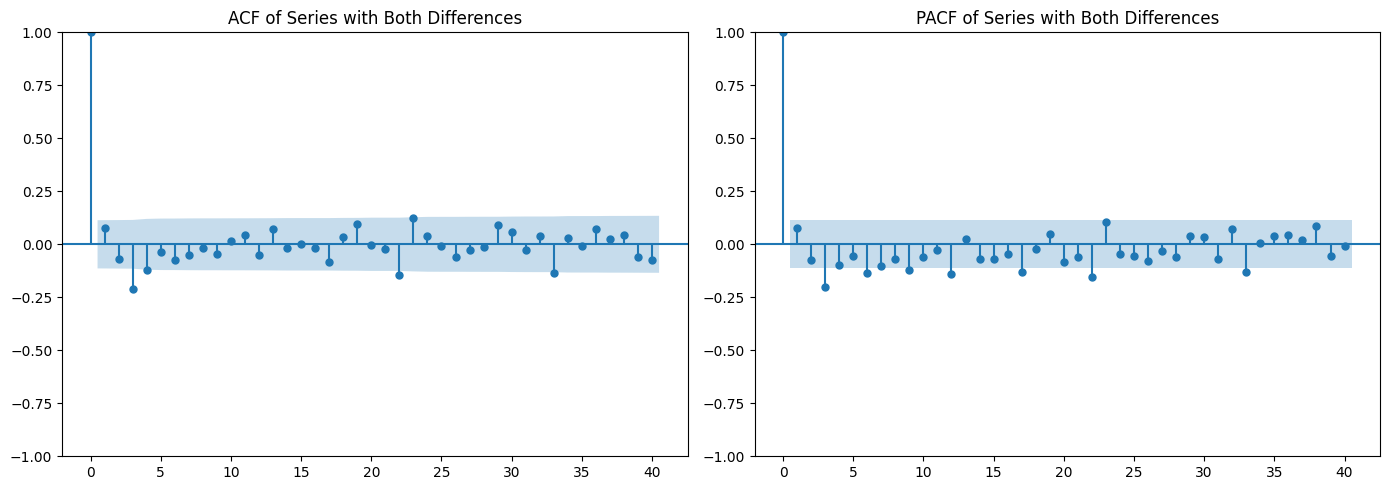

In [ ]:
# Create ACF and PACF plots for the series with First difference
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# ACF Plot
sm.graphics.tsa.plot_acf(both_diff, lags=40, ax=axs[0])
axs[0].set_title("ACF of Series with Both Differences")

# PACF Plot
sm.graphics.tsa.plot_pacf(both_diff, lags=40, ax=axs[1], method='ywm')
axs[1].set_title("PACF of Series with Both Differences")

plt.tight_layout()
plt.show()

In [ ]:
import itertools
import numpy as np 

# Define the grid for non-seasonal parameters p, q and seasonal parameters P, Q
p_values = range(3)
q_values = range(3)
P_values = range(3)
Q_values = range(3)

# Fixed differencing orders and seasonal period
d = 1
D = 1
s = 365

# List to store results
results_list = []

# Grid search over all combinations of p, q, P, Q
for p, q, P, Q in itertools.product(p_values, q_values, P_values, Q_values):
    order = (p, d, q)
    seasonal_order = (P, D, Q, s)
    try:
        model = sm.tsa.SARIMAX(series, order=order, seasonal_order=seasonal_order)
        result = model.fit(disp=False)
        results_list.append({
            'p': p, 'd': d, 'q': q,
            'P': P, 'D': D, 'Q': Q, 's': s,
            'AIC': result.aic, 'BIC': result.bic
        })
    except Exception as e:
        # In case the model fails to fit, record NaN for AIC and BIC.
        results_list.append({
            'p': p, 'd': d, 'q': q,
            'P': P, 'D': D, 'Q': Q, 's': s,
            'AIC': np.nan, 'BIC': np.nan
        })

# Convert the list of results into a DataFrame and sort by BIC (or AIC)
results_df = pd.DataFrame(results_list)
results_df = results_df.sort_values(by='BIC')
print(results_df)

c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\ricar\AppData\Local\Programs\Python\Python313\Lib\s